In [ ]:
!pip install -U torch torchvision
!pip install cython pyyaml
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [3]:
import numpy as np
import cv2
import random

# import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

## Download dataset from roboflow

In [ ]:
!curl -L "https://app.roboflow.com/ds/Gi0F1ODVCA?key=8tX1roLugU" > roboflow.zip; unzip -o roboflow.zip; rm roboflow.zip

In [12]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train/_annotations.coco.json", "train")
register_coco_instances("my_dataset_val", {}, "valid/_annotations.coco.json", "valid")
register_coco_instances("my_dataset_test", {}, "test/_annotations.coco.json", "/content/test")


# Visualize the data

In [3]:
import matplotlib.pyplot as plt
def imshow(image):
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()

WARNING [05/27 00:29:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[05/27 00:29:22 d2.data.datasets.coco]: Loaded 2014 images in COCO format from train/_annotations.coco.json
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='/home/tinapyp/Dependencies/miniconda3/envs/test2/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf', name='DejaVu Sans Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='/home/tinapyp/Dependencies/miniconda3/envs/test2/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='/home/tinapyp/Dependencies/miniconda3/envs/test2/lib/python

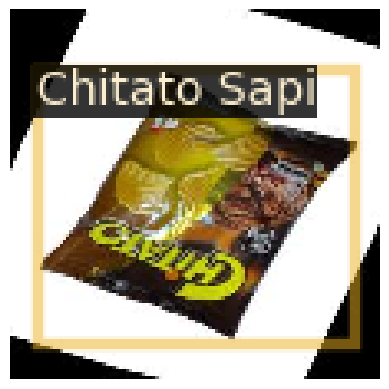

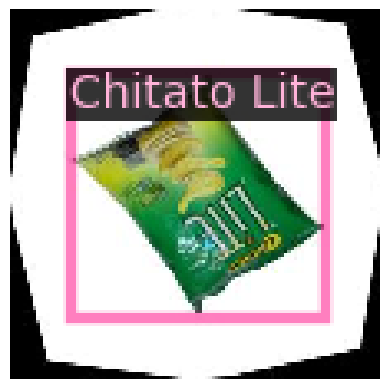

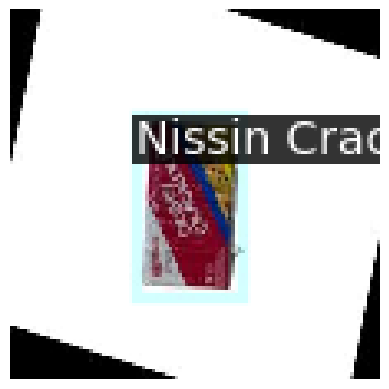

In [14]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    imshow(vis.get_image()[:, :, ::-1])

# Create Model

In [15]:
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
import os

cfg = get_cfg() #konfigurasi detectron
# cfg.MODEL.DEVICE='cpu'
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")) #konfigurasi model
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4 #saat pemrosesan load 4 data per iterasi
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml")  #menggunakan weight dari pretained model
cfg.SOLVER.IMS_PER_BATCH = 4 #saat proses menggunakan 4 data per iterasi
cfg.SOLVER.BASE_LR = 0.001 #learning rate

cfg.SOLVER.WARMUP_ITERS = 100 #100 iterasi awal lr dimulai dari 0 sampai 0.001
cfg.SOLVER.MAX_ITER = 900 #epoch/iterasi
# cfg.SOLVER.STEPS = (1000, 1500) #menentukan pada iterasi ke berapa lr diturunkan dgn lr x gamma
# cfg.SOLVER.GAMMA = 0.05 #faktor penurunan lr


cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64 #batch size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11 #class + 1 (background)

cfg.TEST.EVAL_PERIOD = 100 #pada iterasi ke 100 model dievaluasi menggunakan data validasi

In [16]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import HookBase
from detectron2.data import build_detection_train_loader
import detectron2.utils.comm as comm

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

class ValidationLoss(HookBase):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg.clone()
        self.cfg.DATASETS.TRAIN = cfg.DATASETS.TEST
        self._loader = iter(build_detection_train_loader(self.cfg))

    def after_step(self):
        data = next(self._loader)
        with torch.no_grad():
            loss_dict = self.trainer.model(data)

            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {"val_" + k: v.item() for k, v in
                                 comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                self.trainer.storage.put_scalars(total_val_loss=losses_reduced,
                                                 **loss_dict_reduced)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
cfg.MODEL.DEVICE='cpu'
trainer = CocoTrainer(cfg)
val_loss = ValidationLoss(cfg)
trainer.register_hooks([val_loss])
# swap the order of PeriodicWriter and ValidationLoss
trainer._hooks = trainer._hooks[:-2] + trainer._hooks[-2:][::-1]
trainer.resume_or_load(resume=False)
trainer.train()

# Save Model

In [21]:
torch.save(trainer.model.state_dict(), 'saved_model/model.pth')

# Predict

[05/27 08:28:26 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ../saved_model/model.pth ...


(-0.5, 6047.5, 8063.5, -0.5)

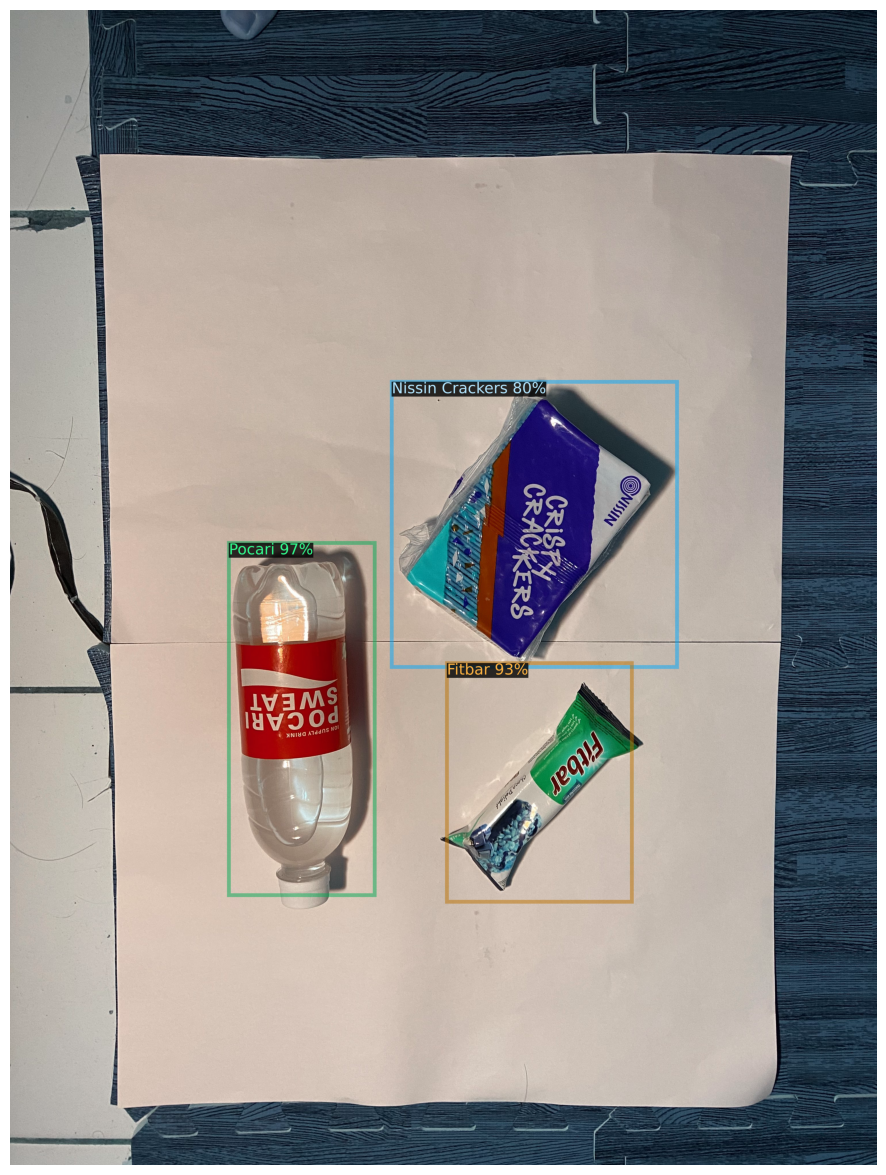

In [10]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
import cv2
import matplotlib.pyplot as plt

# Define the class names
class_names = ["produk", "Biskuit Selamat", "Chiki Twist", "Chitato Lite", 
               "Chitato Sapi", "Fitbar", "Nissin Crackers", "Pocari", 
               "Pop Mie", "Roma Kelapa", "Teh Botol"]

# Register metadata
MetadataCatalog.get("custom_dataset").thing_classes = class_names

# Set up the configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_C4_3x.yaml"))

# Set model weights and other settings
cfg.MODEL.WEIGHTS = "../saved_model/model.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Threshold confidence score for detection results
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 11  # Number of classes + 1 (background)
cfg.MODEL.DEVICE = 'cpu'  # Use CPU for inference

# Create predictor object for prediction
predictor = DefaultPredictor(cfg)

# Read the image
imageName = "/home/tinapyp/Work/FastWork/test2/data/raw/data uji/3_object/IMG_2571.jpg"
im = cv2.imread(imageName)

# Get prediction results
outputs = predictor(im)

# Get custom metadata
test_metadata = MetadataCatalog.get("custom_dataset")

# Create a Visualizer object with a larger scale
v = Visualizer(im[:, :, ::-1], metadata=test_metadata, scale=2.0)  # Increase the scale to make the image bigger

# Draw instance predictions
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# Display the image using matplotlib
plt.figure(figsize=(15, 15))  # Set the figure size to make the image bigger
plt.imshow(out.get_image()[:, :, ::-1])
plt.axis('off')  # Hide